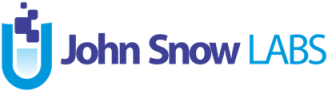

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/llm_notebooks/dataset-notebooks/JSL_Medical_LLM.ipynb)

**LangTest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy** models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification, fill-mask, Translation model using the library. We also support testing LLMS for Question-Answering, Summarization and text-generation tasks on benchmark datasets. The library supports 60+ out of the box tests. For a complete list of supported test categories, please refer to the [documentation](http://langtest.org/docs/pages/docs/test_categories).

Metrics are calculated by comparing the model's extractions in the original list of sentences against the extractions carried out in the noisy list of sentences. The original annotated labels are not used at any point, we are simply comparing the model against itself in a 2 settings.

## Initial setup

In [1]:
import os

os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [ ]:
PUBLIC_VERSION = license_keys['PUBLIC_VERSION']
JSL_VERSION = license_keys['JSL_VERSION']
SECRET = license_keys['SECRET']

# Installing pyspark and spark-nlp
!pip install --upgrade -q pyspark==3.4.1  spark-nlp=={PUBLIC_VERSION}

# Installing Spark NLP Healthcare
!pip install --upgrade -q spark-nlp-jsl=={JSL_VERSION}  --extra-index-url https://pypi.johnsnowlabs.com/{SECRET}

# Installing Spark NLP Display Library for visualization
!pip install -q spark-nlp-display

In [3]:
import os
import json

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.pretrained import ResourceDownloader

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

import numpy as np

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.serializer": "org.apache.spark.serializer.KryoSerializer",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'], params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 5.5.2
Spark NLP_JSL Version : 5.5.2


# Getting started with LangTest

## Question-Answering

In [4]:
prompt = """
You are a biomedical research assistant. You are given a context (an excerpt from a PubMed article) and a research question. 
Your task is to determine whether the evidence in the context supports the question by answering only "Yes" or "No". 
Note: Do not provide any additional explanation or commentary.

Example Format:
CONTEXT: [insert PubMed abstract or excerpt here]
QUESTION: [insert research question here]
ANSWER: Yes or No

Based strictly on the provided content, choose the answer that is factually supported. Begin!

CONTEXT: {context}
QUESTION: {question}
ANSWER:"""

prompt

'\nYou are a biomedical research assistant. You are given a context (an excerpt from a PubMed article) and a research question. \nYour task is to determine whether the evidence in the context supports the question by answering only "Yes" or "No". \nNote: Do not provide any additional explanation or commentary.\n\nExample Format:\nCONTEXT: [insert PubMed abstract or excerpt here]\nQUESTION: [insert research question here]\nANSWER: Yes or No\n\nBased strictly on the provided content, choose the answer that is factually supported. Begin!\n\nCONTEXT: {context}\nQUESTION: {question}\nANSWER:'

### Setup Model from Spark NLP

In [5]:
document_assembler = MultiDocumentAssembler()\
    .setInputCols("question", "context")\
    .setOutputCols("document_question", "document_context")

med_qa = MedicalQuestionAnswering().pretrained("clinical_notes_qa_base_onnx", "en", "clinical/models")\
    .setInputCols(["document_question", "document_context"])\
    .setCustomPrompt(prompt)\
    .setOutputCol("answer") \
    .setMaxNewTokens(30)\
    .setTopK(1)\
    .setQuestionType("short") # "long"

pipeline = Pipeline(stages=[document_assembler, med_qa])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)

clinical_notes_qa_base_onnx download started this may take some time.
[OK!]


### Harness and Its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

In [ ]:
#Import Harness from the LangTest library
from langtest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.

Here is a list of the different parameters that can be passed to the Harness function:

<br/>


| Parameter  | Description |  
| - | - |
|**task**     |Task for which the model is to be evaluated (question-answering or summarization)|
| **model**     | Specifies the model(s) to be evaluated. This parameter can be provided as either a dictionary or a list of dictionaries. Each dictionary should contain the following keys: <ul><li>model (mandatory): 	PipelineModel or path to a saved model or pretrained pipeline/model from hub.</li><li>hub (mandatory): Hub (library) to use in back-end for loading model from public models hub or from path</li></ul>|
| **data**      | The data to be used for evaluation. A dictionary providing flexibility and options for data sources. It should include the following keys: <ul><li>data_source (mandatory): The source of the data.</li><li>subset (optional): The subset of the data.</li><li>feature_column (optional): The column containing the features.</li><li>target_column (optional): The column containing the target labels.</li><li>split (optional): The data split to be used.</li><li>source (optional): Set to 'huggingface' when loading Hugging Face dataset.</li></ul> |
| **config**    | Configuration for the tests to be performed, specified in the form of a YAML file. |

<br/>
<br/>

## PubMedQA

[PubMedQA: A Dataset for Biomedical Research Question Answering](https://arxiv.org/abs/1909.06146)

**Dataset Summary**

The PubMedQA is a benchmark dataset for biomedical question answering (QA) dataset collected from PubMed abstracts. The task of PubMedQA is to answer research questions with yes/no/maybe (e.g.: Do preoperative statins reduce atrial fibrillation after coronary artery bypass grafting?) using the corresponding abstracts.

**Data Splits**

- **pqaa** : Truncated version of pqa_artificial subset from the PubMedQA, containing 500 question and answers examples.
- **pqal** : Truncated version of pqa_labeled subset from the PubMedQA, containing 500 question answers examples.

### Setup and Configure Harness

In [7]:
harness = Harness(
    task="question-answering",
    model={"model": model, "hub": "johnsnowlabs"},
    data={"data_source": "PubMedQA",
          "subset": "pqaa",
          "split": "test"},
    config={
        
        "evaluation": {
            "metric":"embedding_distance","distance":"cosine","threshold":0.95},
        'tests': {
            'defaults': {'min_pass_rate': 0.65},
            'robustness': {
                'add_slangs': {'min_pass_rate': 0.66},
                'dyslexia_word_swap': {'min_pass_rate': 0.60},
                "add_new_lines": {"min_pass_rate": 0.60},
            }
        }
    }
)

Test Configuration : 
 {
 "evaluation": {
  "metric": "embedding_distance",
  "distance": "cosine",
  "threshold": 0.95
 },
 "tests": {
  "defaults": {
   "min_pass_rate": 0.65
  },
  "robustness": {
   "add_slangs": {
    "min_pass_rate": 0.66
   },
   "dyslexia_word_swap": {
    "min_pass_rate": 0.6
   },
   "add_new_lines": {
    "min_pass_rate": 0.6
   }
  }
 }
}


Note: for evaluation we are using **embedding_distance metrics**

Let us run it for 20 examples

In [8]:
harness.data =harness.data[:20]

### Generating the test cases.

In [9]:
harness.generate()

Generating testcases...: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [ ]:
testcases_df = harness.testcases()
testcases_df.head()

,category,test_type,original,test_case,expected_result
0,robustness,add_ocr_typo,The ex-Reading defender denied fraudulent trad...,tlie ex-Reading defender denied fraudulent tra...,The ex-Reading defender denied fraudulent trad...
1,robustness,add_ocr_typo,Voges was forced to retire hurt on 86 after su...,Voges was forced t^o retire hurt on 86 aftei s...,The 37-year-old Australian was injured while b...
2,robustness,add_ocr_typo,Seven photographs taken in the Norfolk country...,feven photographs taken i^n t^ie Norfolk count...,The Duchess of Cambridge has been photographed...
3,robustness,add_ocr_typo,"Chris Poole - known as ""moot"" online - created...","Chris Poole - known as ""moot"" online - created...","The former administrator of 4chan, Chris Poole..."
4,robustness,add_ocr_typo,Four police officers were injured in the incid...,f0ur pol1ce officers were injured i^n tlic inc...,A 19-year-old man and a 16-year-old boy have b...


### Running the tests

In [11]:
harness.run()

Running testcases... : 100%|██████████| 58/58 [01:04<00:00,  1.11s/it]


### Generated Results

In [12]:
results_df = harness.generated_results()
results_df.head()

,category,test_type,original_context,original_question,perturbed_context,perturbed_question,expected_result,actual_result,eval_score,pass
0,robustness,add_slangs,Context (1): Catharanthus roseus L (C. roseus)...,does catharanthus roseus flower extract have w...,Context (1): Catharanthus roseus L (C. roseus)...,does catharanthus roseus flower extract have w...,"Yes, the flower extract of Catharanthus roseus...","Yes, the flower extract of Catharanthus roseus...",1.0,True
1,robustness,add_slangs,Context (1): We intended to investigate whethe...,does regional ischemic preconditioning enhance...,Context (1): We intended to investigate whethe...,does regional ischemic preconditioning enhance...,"Yes, regional ischemic preconditioning (IP) en...","Yes, regional ischemic preconditioning (IP) en...",1.0,True
2,robustness,add_slangs,Context (1): Experimental evidence indicates t...,do proteomic analysis of the ins-1e secretome ...,Context (1): Experimental evidence indicates t...,do proteomic analysis of the ins-1e secretome ...,"Yes, proteomic analysis of the ins-1e secretom...","Yes, proteomic analysis of the ins-1e secretom...",1.0,True
3,robustness,add_slangs,Context (1): Hepatitis C virus (HCV) infection...,does serum cystatin c correlate negatively wit...,Context (1): Hepatitis C virus (HCV) infection...,does serum cystatin c correlate negatively wit...,"No, cystatin C levels were significantly highe...","No, cystatin C levels were significantly highe...",1.0,True
4,robustness,add_slangs,Context (1): The prophylactic use of the impla...,do implantable cardioverter-defibrillators con...,Context (1): The prophylactic use of the impla...,do implantable cardioverter-defibrillators con...,"Yes, the prophylactic use of the implantable c...","Yes, the prophylactic use of the implantable c...",1.0,True


### Final Results

In [13]:
harness.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,add_slangs,2,16,89%,66%,True
1,robustness,dyslexia_word_swap,4,16,80%,60%,True
2,robustness,add_new_lines,0,20,100%,60%,True


## Summarization

### Setup Model from Spark NLP

In [15]:
document_assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')

summarizer = MedicalSummarizer.pretrained("summarizer_clinical_jsl", "en", "clinical/models")\
    .setInputCols(['document'])\
    .setOutputCol('summary')\
    .setMaxTextLength(512)\
    .setMaxNewTokens(512)

pipeline = Pipeline(
    stages=[
        document_assembler,
        summarizer
])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))


summarizer_clinical_jsl download started this may take some time.
[OK!]


### Harness and Its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.

Here is a list of the different parameters that can be passed to the Harness function:

<br/>


| Parameter  | Description |  
| - | - |
|**task**     |Task for which the model is to be evaluated (question-answering or summarization)|
| **model**     | Specifies the model(s) to be evaluated. This parameter can be provided as either a dictionary or a list of dictionaries. Each dictionary should contain the following keys: <ul><li>model (mandatory): 	PipelineModel or path to a saved model or pretrained pipeline/model from hub.</li><li>hub (mandatory): Hub (library) to use in back-end for loading model from public models hub or from path</li></ul>|
| **data**      | The data to be used for evaluation. A dictionary providing flexibility and options for data sources. It should include the following keys: <ul><li>data_source (mandatory): The source of the data.</li><li>subset (optional): The subset of the data.</li><li>feature_column (optional): The column containing the features.</li><li>target_column (optional): The column containing the target labels.</li><li>split (optional): The data split to be used.</li><li>source (optional): Set to 'huggingface' when loading Hugging Face dataset.</li></ul> |
| **config**    | Configuration for the tests to be performed, specified in the form of a YAML file. |

<br/>
<br/>

### Setup and Configure Harness

In [16]:
from langtest import Harness 

harness = Harness(
    task="summarization",
    model={
        "model": model,
        "hub": "johnsnowlabs",
    },
    data={
        "data_source": "XSum",
        "split": "test-tiny",
    },
    config={ 
        "evaluation":{"metric": "rouge", "threshold": 0.30},
        "tests": {
            "defaults": {
                "min_pass_rate": 0.5,
            },
            "robustness": {
                "add_ocr_typo": {
                    "min_pass_rate": 0.5,
                },
            }
        },
    }
)

Test Configuration : 
 {
 "evaluation": {
  "metric": "rouge",
  "threshold": 0.3
 },
 "tests": {
  "defaults": {
   "min_pass_rate": 0.5
  },
  "robustness": {
   "add_ocr_typo": {
    "min_pass_rate": 0.5
   }
  }
 }
}


Note: for evaluation we are using **embedding_distance metrics**

Let us run it for 5 examples

In [17]:
harness.data = harness.data[:5]

### Generating and Execute the test cases.

In [18]:
harness.generate().run()

Running testcases... : 100%|██████████| 5/5 [00:51<00:00, 10.31s/it]


### Generated Results

In [19]:
harness.generated_results()

,category,test_type,original,test_case,expected_result,actual_result,eval_score,pass
0,robustness,add_ocr_typo,The ex-Reading defender denied fraudulent trad...,tlie ex-Reading defender denied fraudulent tra...,The ex-Reading defender denied fraudulent trad...,The ex-Reading defender has denied fraudulent ...,0.375000,True
1,robustness,add_ocr_typo,Voges was forced to retire hurt on 86 after su...,Voges was forced t^o retire hurt on 86 aftei s...,The 37-year-old Australian was injured while b...,"The report describes the injury of Adam Voges,...",0.309392,True
2,robustness,add_ocr_typo,Seven photographs taken in the Norfolk country...,feven photographs taken i^n t^ie Norfolk count...,The Duchess of Cambridge has been photographed...,The Duchess of Cambridge has been photographed...,0.607330,True
3,robustness,add_ocr_typo,"Chris Poole - known as ""moot"" online - created...","Chris Poole - known as ""moot"" online - created...","The former administrator of 4chan, Chris Poole...",The man who created the slte in 2003 is a well...,0.120000,False
4,robustness,add_ocr_typo,Four police officers were injured in the incid...,f0ur pol1ce officers were injured i^n tlic inc...,A 19-year-old man and a 16-year-old boy have b...,A 19-year-old man and a 16-year-old boy were i...,0.437500,True


In [20]:
harness.report()

,category,test_type,fail_count,pass_count,pass_rate,minimum_pass_rate,pass
0,robustness,add_ocr_typo,1,4,80%,50%,True
